 # Types of Regression in Machine Learning
1. **Linear Regression**  
   Predicts a target variable using a straight line based on a linear relationship between input and output.

2. **Polynomial Regression**  
   Extends linear regression by adding polynomial terms, allowing it to model non-linear relationships.

3. **Stepwise Regression**  
   Iteratively adds or removes features based on statistical criteria to improve model performance.

4. **Decision Tree Regression**  
   Splits data into regions using decision rules, predicting the mean output for each region.

5. **Random Forest Regression**  
   An ensemble of decision trees that improves accuracy by averaging predictions from multiple trees.

6. **Support Vector Regression (SVR)**  
   Uses the principles of Support Vector Machines to fit the best line within a margin of tolerance.

7. **Ridge Regression**  
   A linear model with L2 regularization to reduce overfitting by shrinking coefficients.

8. **ElasticNet Regression**  
   Combines L1 and L2 regularization for a balance between Ridge and Lasso.



# *Preprocessing*

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

# Dataset path
dataset_path = "/kaggle/input/house-prices-advanced-regression-techniques"

# Load train.csv
df = pd.read_csv(f"{dataset_path}/train.csv")

# Drop columns with too many missing values or not useful for regression
drop_cols = ['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature']
df.drop(columns=drop_cols, inplace=True)

# Separate features and target
X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

# Numerical pipeline
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Categorical pipeline
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Full preprocessing pipeline
preprocessor = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

# Apply transformations
X_processed = preprocessor.fit_transform(X)

# Convert processed array to DataFrame
X_processed_df = pd.DataFrame(X_processed)

# Save preprocessed dataset
X_processed_df.to_csv("train_processed.csv", index=False)
y.to_csv("train_target.csv", index=False)

print("✅ Preprocessing completed and saved as train_processed.csv and train_target.csv")


✅ Preprocessing completed and saved as train_processed.csv and train_target.csv


# PyTorch Neural Network - Training & Accuracy

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

# -------------------------------
# Load preprocessed data
X = pd.read_csv("train_processed.csv")
y = pd.read_csv("train_target.csv")

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)

# DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=64)

# -------------------------------
# Model Definition
class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.model(x)

# -------------------------------
# Training Setup
model = RegressionModel(X_train.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# -------------------------------
# Training Loop
epochs = 50
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val_tensor)
        val_loss = criterion(val_preds, y_val_tensor)

    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {loss.item():.2f}, Val Loss: {val_loss.item():.2f}")

# -------------------------------
# Accuracy Calculation (MAPE-based)
def regression_accuracy(y_true, y_pred):
    y_true = y_true.numpy()
    y_pred = y_pred.numpy()
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return 100 - mape

accuracy = regression_accuracy(y_val_tensor, val_preds)
print(f"\n✅ Final Regression Accuracy (approx): {accuracy:.2f}%")


Epoch [1/50], Train Loss: 34410897408.00, Val Loss: 39652474880.00
Epoch [2/50], Train Loss: 28471203840.00, Val Loss: 39643025408.00
Epoch [3/50], Train Loss: 37043314688.00, Val Loss: 39612784640.00
Epoch [4/50], Train Loss: 36507033600.00, Val Loss: 39542714368.00
Epoch [5/50], Train Loss: 30059880448.00, Val Loss: 39409201152.00
Epoch [6/50], Train Loss: 29192488960.00, Val Loss: 39186841600.00
Epoch [7/50], Train Loss: 23064268800.00, Val Loss: 38850121728.00
Epoch [8/50], Train Loss: 36938883072.00, Val Loss: 38374150144.00
Epoch [9/50], Train Loss: 38387531776.00, Val Loss: 37731237888.00
Epoch [10/50], Train Loss: 34926071808.00, Val Loss: 36904648704.00
Epoch [11/50], Train Loss: 31058849792.00, Val Loss: 35874963456.00
Epoch [12/50], Train Loss: 37492396032.00, Val Loss: 34643587072.00
Epoch [13/50], Train Loss: 32886665216.00, Val Loss: 33184065536.00
Epoch [14/50], Train Loss: 26549196800.00, Val Loss: 31506638848.00
Epoch [15/50], Train Loss: 31126892544.00, Val Loss: 2965

# Polynomial Regression

✅ Polynomial Regression MSE: 1225563396.03
✅ R² Score: 0.8402
✅ Accuracy (MAPE-based): 84.39%


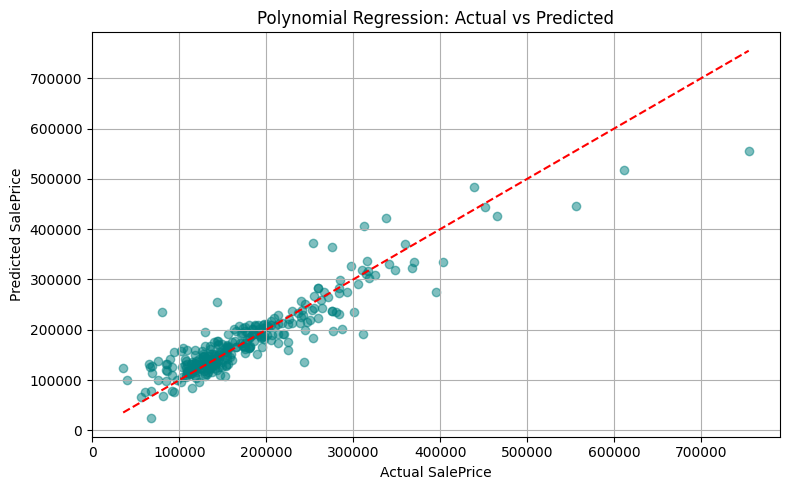

In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load dataset
X = pd.read_csv("train_processed.csv")
y = pd.read_csv("train_target.csv")

# Encode categorical variables
X_encoded = pd.get_dummies(X, drop_first=True)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Polynomial feature transformation
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train_scaled)
X_poly_val = poly.transform(X_val_scaled)

# Train polynomial regression
poly_model = LinearRegression()
poly_model.fit(X_poly_train, y_train)
poly_preds = poly_model.predict(X_poly_val)

# Evaluation
poly_mse = mean_squared_error(y_val, poly_preds)
poly_r2 = r2_score(y_val, poly_preds)
mape = np.mean(np.abs((y_val.values.flatten() - poly_preds.flatten()) / y_val.values.flatten())) * 100
accuracy = 100 - mape

# Print metrics
print(f"✅ Polynomial Regression MSE: {poly_mse:.2f}")
print(f"✅ R² Score: {poly_r2:.4f}")
print(f"✅ Accuracy (MAPE-based): {accuracy:.2f}%")

# Visualization
plt.figure(figsize=(8, 5))
plt.scatter(y_val, poly_preds, alpha=0.5, color='teal')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title('Polynomial Regression: Actual vs Predicted')
plt.grid(True)
plt.tight_layout()
plt.show()


**MSE = Mean Squared Error
It calculates the average of the squared differences between your model’s predicted values and the actual values**

Why is the number so large?
Because you're predicting house prices, which are often in the hundreds of thousands. So:

A small error (say, ₹10,000) when squared becomes 100,000,000.

These large squared errors accumulate, so your final MSE is also large.



# Random Forest Regression

🌲 Random Forest Regression MSE: 826983245.52
🌲 R² Score: 0.8922
🌲 Accuracy (MAPE-based): 89.29%


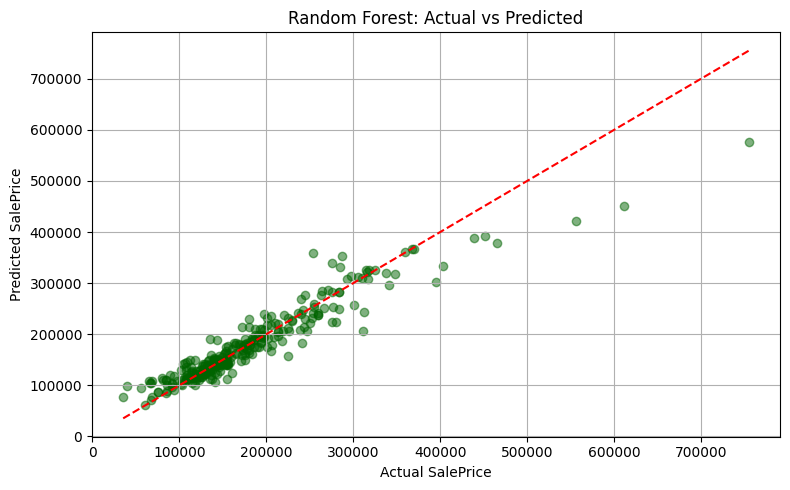

In [24]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# Reshape y to 1D
y_train_1d = y_train.values.ravel()

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train_1d)

# Predict
rf_preds = rf_model.predict(X_val)

# Evaluation
rf_mse = mean_squared_error(y_val, rf_preds)
rf_r2 = r2_score(y_val, rf_preds)
rf_mape = np.mean(np.abs((y_val.values.flatten() - rf_preds.flatten()) / y_val.values.flatten())) * 100
rf_accuracy = 100 - rf_mape

# Print results
print(f"🌲 Random Forest Regression MSE: {rf_mse:.2f}")
print(f"🌲 R² Score: {rf_r2:.4f}")
print(f"🌲 Accuracy (MAPE-based): {rf_accuracy:.2f}%")

# Graph: Actual vs Predicted
plt.figure(figsize=(8, 5))
plt.scatter(y_val, rf_preds, alpha=0.5, color='darkgreen')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Random Forest: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


# Linear Regression

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_preds = lr_model.predict(X_val)
lr_mse = mean_squared_error(y_val, lr_preds)
print("Linear Regression MSE:", lr_mse)

Linear Regression MSE: 1.9658204389646654e+27


# Stepwise Regression

In [14]:
import statsmodels.api as sm

def forward_selected(X, y):
    initial_features = []
    best_features = []
    while True:
        remaining_features = list(set(X.columns) - set(initial_features))
        new_pval = pd.Series(index=remaining_features, dtype=float)
        for new_column in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[initial_features + [new_column]])).fit()
            new_pval[new_column] = model.pvalues[new_column]
        min_p_value = new_pval.min()
        if min_p_value < 0.05:
            best_feature = new_pval.idxmin()
            initial_features.append(best_feature)
            best_features = initial_features.copy()
        else:
            break
    return best_features

selected_features = forward_selected(X_train, y_train)
stepwise_model = LinearRegression()
stepwise_model.fit(X_train[selected_features], y_train)
stepwise_preds = stepwise_model.predict(X_val[selected_features])
stepwise_mse = mean_squared_error(y_val, stepwise_preds)
print("Stepwise Regression MSE:", stepwise_mse)


Stepwise Regression MSE: 798997301.593747


# Decision Tree Regression

In [15]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor()
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_val)
dt_mse = mean_squared_error(y_val, dt_preds)
print("Decision Tree Regression MSE:", dt_mse)


Decision Tree Regression MSE: 1615046351.109589


# Vector Regression

In [17]:
from sklearn.svm import SVR

svr_model = SVR()
svr_model.fit(X_train, y_train.values.ravel())
svr_preds = svr_model.predict(X_val)
svr_mse = mean_squared_error(y_val, svr_preds)
print("Support Vector Regression MSE:", svr_mse)


Support Vector Regression MSE: 7854512162.828414


# Ridge Regression

In [18]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
ridge_preds = ridge_model.predict(X_val)
ridge_mse = mean_squared_error(y_val, ridge_preds)
print("Ridge Regression MSE:", ridge_mse)


Ridge Regression MSE: 863065420.605551


# ElasticNet Regression

In [20]:
from sklearn.linear_model import ElasticNet

en_model = ElasticNet(alpha=0.1, l1_ratio=0.5)
en_model.fit(X_train, y_train)
en_preds = en_model.predict(X_val)
en_mse = mean_squared_error(y_val, en_preds)
print("ElasticNet Regression MSE:", en_mse)


ElasticNet Regression MSE: 1015603420.046698
